# Modern CNN Architectures and Transfer Learning in Keras

In this notebook we'll illustrate a sample implementation of the ResNET-34 architecture, as well as using a pretrained model for transfer learning.

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline

## Implementing ResNET-34 using Keras

We can use Keras to build different CNN architectures without much hassle, by simply using the available tools.

For example, if we want to build a ResNET-34 model, we could start by creating a class representing the ResidualUnit, which is simply formed by a couple of `Conv2D` layers, with `BatchNormalization` between them.

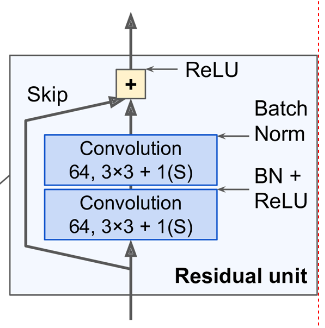

### Batch Normalization

Batch Normalization can be easily added to any model through a [`BatchNormalization`](https://keras.io/api/layers/normalization_layers/batch_normalization/) layer. Notice that it's possible to add normalization either before or after the layer's activation (although general consensus suggests putting it before the activation).

```
# Placing BN after activation
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
```
```
# Placing BN before activation
x = layers.Conv2D(32, 3, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
```

Another element to consider is that both `Dense` and `Conv2D` layers involve a bias vector, a learned variable whose purpose is to make the layer affine rather than purely linear. For instance, `Conv2D` returns, schematically, `y = conv(x, kernel) + bias`, and `Dense` returns `y = dot(x, kernel) + bias`. Because the normalization step will take care of centering the layer's output on zero, the bias vector is no longer needed when using `BatchNormalization`, and the layer can be created without it via the option `use_bias=False`. This makes the layer slightly leaner.

### Optimizing with Depthwise Convolution

As disscused previously, depthwise convolution is an alternative to traditional convolution that first acts separately on channels, followed second by a pointwise convolution that mixes channels. This change offers similar expressive power at a fraction of the cost (both in memory and execution). For our `ResidalUnit`, we will replace traditional `Conv2d` layers with [`SeparableConv2d`](https://keras.io/api/layers/convolution_layers/separable_convolution2d/) layers.

### Building the ResidualUnit

We will start by extending the base `keras.layers.Layer` class. Although keras comes packed with several different types of layers, from time to time we will need to define our own custom layers under two possible scenarios:
- Define a new type of layer with a specialized function. In this case, we'll need to define the trainable and non-trainable layer parameters as well as the computations the layer will perform when called.
- Define a block of layers to be used to build a specific model architecture. In this case, we'll simply need to add the relevant layers to the block and use them on the inputs when called.

For both cases, the procedure is generally straightforward, check the guide on [Making new layers and models via subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) for more information.

In particular, for this example we'll define a block of `SeparableConv2d` layers with a skip connection as follows. Notice we also added an extra `SeparableConv2d` layer to resize the input if we use a stride greater than 2. This will ensure the input and the block's output dimensions match when we add them (this won't be used if the stride is equal to 1).

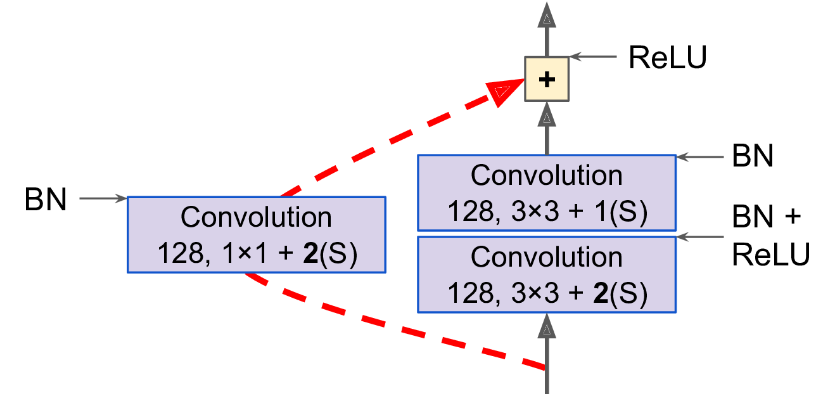

In [ ]:
class ResidualUnit(keras.layers.Layer): # Extend base Layer class
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) # Call Layer's init
        self.activation = keras.activations.get(activation) # Get activation layer
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: # Resize input if needed
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Pay special attention to the `call` method, where, to implement the skip connections, we return the sum of the last layer's output (having passed through all the layers in `main_layers`) plus the original input (having passed through the resizing layers in `skip_layers` if needed).

The next step is to simply use these special `ResidualUnit` layers to build the full model. Note that the assumption that underlies separable convolution, "feature channels are largely independent" does not hold for RGB images! Red, green, and blue color channels are actually highly correlated in natural images. As such, the first layer in our model will be a regular `Conv2D` layer, only using `SeparableConv2D` afterwards.

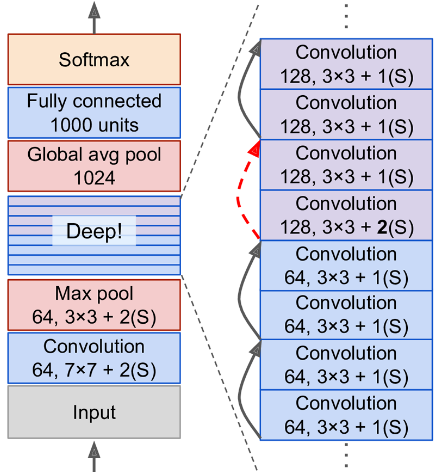

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(180, 180, 3)))

# Data augmentation and scaling
model.add(keras.layers.RandomFlip("horizontal"))
model.add(keras.layers.RandomRotation(0.1))
model.add(keras.layers.RandomZoom(0.2))
model.add(keras.layers.Rescaling(1./255))

# ResNet
model.add(keras.layers.Conv2D(64, 7, strides=2,
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())

# Dropout
model.add(keras.layers.Dropout(0.5))

# Changing the output layer to use with our dataset
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 90, 90, 64)          │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 90, 90, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit (ResidualUnit)         │ (None, 45, 45, 64)          │           9,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_1 (ResidualUnit)       │ (None, 45, 45, 64)          │           9,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_2 (ResidualUnit)       │ (None, 45, 45, 64)          │           9,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_3 (ResidualUnit)       │ (None, 23, 23, 128)         │          36,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_4 (ResidualUnit)       │ (None, 23, 23, 128)         │          36,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_5 (ResidualUnit)       │ (None, 23, 23, 128)         │          36,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_6 (ResidualUnit)       │ (None, 23, 23, 128)         │          36,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_7 (ResidualUnit)       │ (None, 12, 12, 256)         │         137,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_8 (ResidualUnit)       │ (None, 12, 12, 256)         │         137,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_9 (ResidualUnit)       │ (None, 12, 12, 256)         │         137,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_10 (ResidualUnit)      │ (None, 12, 12, 256)         │         137,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_11 (ResidualUnit)      │ (None, 12, 12, 256)         │         137,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ residual_unit_12 (ResidualUnit)      │ (None, 12, 12, 256)         │         137,7

 Total params: 2,623,297 (10.01 MB)

 Trainable params: 2,606,273 (9.94 MB)

 Non-trainable params: 17,024 (66.50 KB)

And that's it. We could now use this model to train/test on some dataset. Notice that the model expects an input image of $180\times180$ pixels with 3 channels, so using it with different sized images would need a little adjusting or preprocessing.

Let's try using this model with our previously made "Dogs vs. Cats" dataset and compare the results.

### Preparing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Choose your directory where you previously saved the dataset
%cd "/content/drive/MyDrive/ConcentracionIAA-2022/TC3007C/code/"

/content/drive/MyDrive/ConcentracionIAA-2022/TC3007C/code


In [ ]:
import os, shutil, pathlib
from keras.utils import image_dataset_from_directory

base_dir = pathlib.Path("cats_vs_dogs_small")

train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


We can check out some of the set's pictures and expected classes.

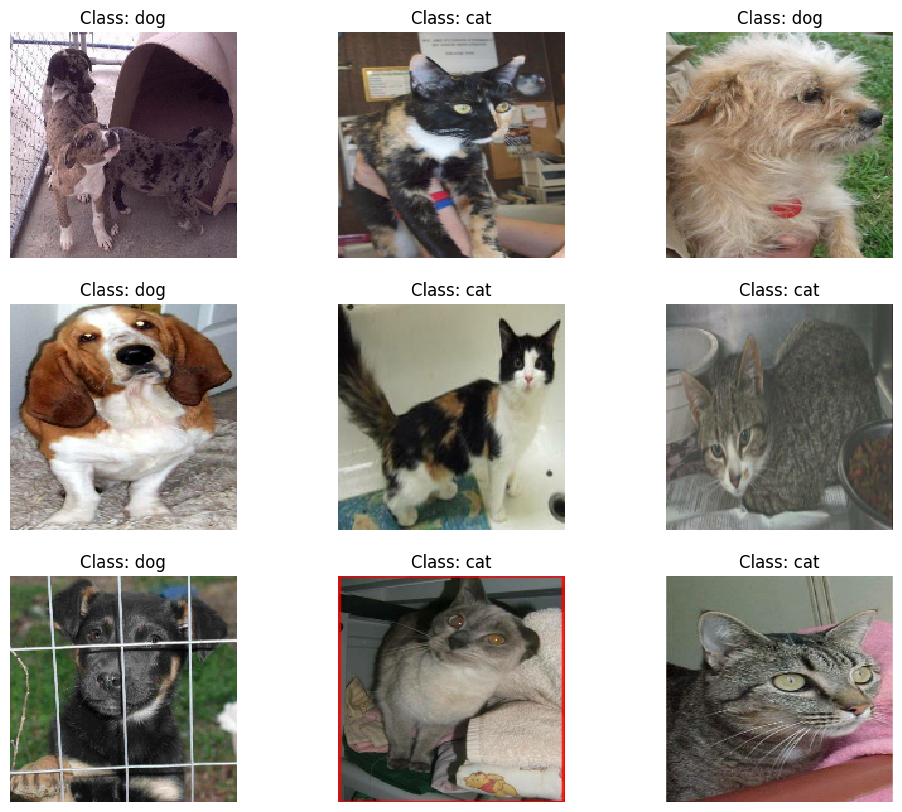

In [ ]:
class_names = ['cat', 'dog']

plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### Compiling and running the model

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="resnet_dsc.keras", save_best_only=True, monitor="val_loss")]

history = model.fit(train_dataset, epochs=30,
                    validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 585s 9s/step - accuracy: 0.4941 - loss: 1.0199 - val_accuracy: 0.5000 - val_loss: 0.6978
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - accuracy: 0.5248 - loss: 0.8351 - val_accuracy: 0.5000 - val_loss: 0.7050
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - accuracy: 0.5754 - loss: 0.7552 - val_accuracy: 0.5000 - val_loss: 0.7246
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 201ms/step - accuracy: 0.5830 - loss: 0.7453 - val_accuracy: 0.5000 - val_loss: 0.7416
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 241ms/step - accuracy: 0.6022 - loss: 0.7222 - val_accuracy: 0.5000 - val_loss: 0.7688
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 215ms/step - accuracy: 0.6159 - loss: 0.7059 - val_accuracy: 0.5000 - val_loss: 0.8351
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.6487 - loss: 0.6777 - val_accuracy: 0.5130 - val_loss: 0.7755
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 249ms/step - accuracy: 0.6289 - loss: 0.6702 - val_accura

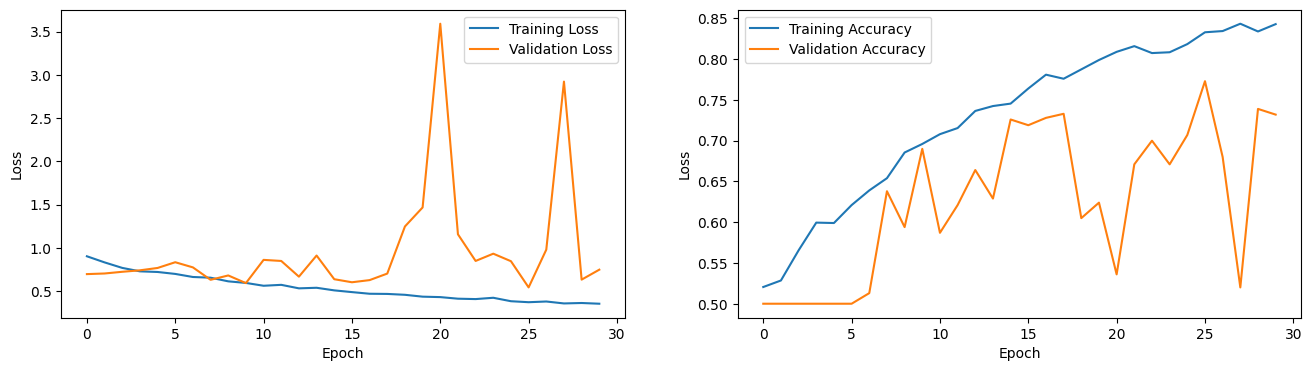

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# model = keras.models.load_model("resnet_dsc.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 542s 9s/step - accuracy: 0.7134 - loss: 0.7712
Test accuracy: 0.715


# Using Pretrained Models from Keras

In practice, however, if we intend to use a standard model it is easier to simply load one of Keras' pretrained models available in the `keras.applications` package.

For instance, we could load the [ResNet-50](https://keras.io/api/applications/resnet/#resnet50-function) model with pretrained weights for the ImageNet dataset with the following line of code:

In [ ]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


As with our previous implementation, this models expects input images of a particular size ($224\times224$ pixels for this model).

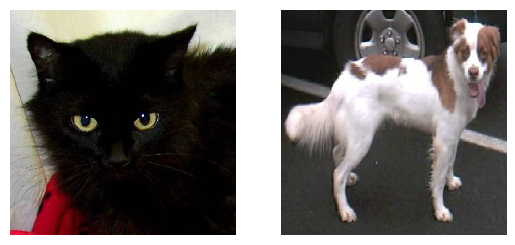

In [ ]:
# Load sample cats_vs_dogs images
cat = keras.utils.load_img('cats_vs_dogs_small/test/cat/cat.1500.jpg', target_size=(224,224))
dog = keras.utils.load_img('cats_vs_dogs_small/test/dog/dog.1500.jpg', target_size=(224,224))
images = np.array([cat, dog])

plt.subplot(121)
plt.imshow(images[0]/255, interpolation="nearest")
plt.axis("off")
plt.subplot(122)
plt.imshow(images[1]/255, interpolation="nearest")
plt.axis("off")
plt.show()

Most models also expect input images being preprocessed in a certain fashion. So we usually need to use the model's `preprocess_input()` function.

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images)

It is also a good idea to make sure our images' pixel values are in the range the model expects. This is usually an integer between 0 and 255, so check your input images and ajust accordingly.

Since the model is already pretrained, you can jump right into making predictions

In [ ]:
Y_proba = model.predict(inputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


And use the `decode_predictions()` function to check the results.

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba*100:.2f}")
    print()

Image #0
  n02123045 - tabby        25.10
  n02124075 - Egyptian_cat 9.26
  n04493381 - tub          7.48

Image #1
  n02101388 - Brittany_spaniel 81.79
  n02102177 - Welsh_springer_spaniel 10.81
  n02100877 - Irish_setter 2.43



We can see that both predictions include relevant clases for each image (types of cats and dogs respectively) among its top 3 predictions (considering that the model is trained on 1000 classes, the results are not too bad).

Note that when using prebuilt models we also have the option to just import the architecture without the weights (omit the `weights` parameter). Doing this means you intend to train the model from scratch, and thus can specify a different target number of `classes`.

You can check a full list of available pretrained models here: https://keras.io/api/applications/

# Transfer Learning

Finally, sometimes you want to train a model on a dataset, but you do not have enough data to start training from scratch, or would like to take advantage of a previously trained model and build on top of it.

Transfer learning is a machine learning method where a model developed for a task is reused as the starting point for a model on a second task. It is a popular approach in deep learning where pre-trained models are used as the starting point on computer vision and natural language processing tasks given the vast compute and time resources required to develop neural network models on these problems and from the huge jumps in skill that they provide on related problems.

To do this we can reuse the lower layers of a pretrained model and build on top of them.

 For this example, we'll be using a pretrained [Xception](https://keras.io/api/applications/xception/) model. Since we only want to reuse the lower layers (which act as feature extractors) we set the `include_top` parameter to `False` (which will omit the classification head). By specifying `weights='imagenet'` we will also load the model's weights after been trained with the ImageNet dataset.

We can then define our top layer as a `Dense` layer with 1 unit (binary classification) and a `sigmoid` activation function and combien both.

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

Next, we need to preprocess the images. Remember, our inputs should match those expected by the pretrained model so we'll need to run them through the corresponding `preprocess_input` function. Since the images in the dataset come in different sizes, we'll resize them all to $299\times299$ (this is the original size used to train the Xception model, we are not forced to use the same image size, however using a similar size to the original training data generally produces good results).

In [ ]:
preprocess = keras.Sequential([
    keras.layers.Resizing(height=299, width=299, crop_to_aspect_ratio=True),
    keras.layers.Lambda(keras.applications.xception.preprocess_input)
])

Finally apply the necessary preporcessing to the images in our dataset.

In [ ]:
train_set = train_dataset.map(lambda X, y: (preprocess(X), y))
valid_set = validation_dataset.map(lambda X, y: (preprocess(X), y))
test_set = test_dataset.map(lambda X, y: (preprocess(X), y))

Before we start training, we'll freeze the base model's layers (meaning its weights won't be adjusted). This will prevent the model from losing its generalized feature extraction capabilities while learning to use them in order to predict our new classes.

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

We can now start training on our dataset.

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.2,
    decay_steps=10000,
    decay_rate=0.01)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 71s 753ms/step - accuracy: 0.9571 - loss: 0.1306 - val_accuracy: 0.9900 - val_loss: 0.0274
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step - accuracy: 0.9968 - loss: 0.0162 - val_accuracy: 0.9940 - val_loss: 0.0159
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.9996 - loss: 0.0048 - val_accuracy: 0.9910 - val_loss: 0.0225
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 387ms/step - accuracy: 0.9985 - loss: 0.0079 - val_accuracy: 0.9950 - val_loss: 0.0122
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 396ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9930 - val_loss: 0.0142
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 403ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9960 - val_loss: 0.0116
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 350ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.9950 - val_loss: 0.0121
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 390ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accu

After the model has trained for a few epochs, and accuracy stops progressing, is time to unfreeze the base layers and continue training. We'll need to recompile the model after unfreezing. It's also a good idea to lower the learning rate to avoid 'damaging' our pretrained layers (we only want to fine tune them). Beware, an incorrect strategy could push your model back instead of forward. Consider saving your model before proceeding so mistakes can be rolled back easily.

In [ ]:
model.save('xception_cat_n_dog_top.keras')

For example, let’s unfreeze layers 56 and above:

In [ ]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.00001)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 73s 931ms/step - accuracy: 0.8639 - loss: 0.6544 - val_accuracy: 0.9810 - val_loss: 0.0568
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 51s 551ms/step - accuracy: 0.8739 - loss: 0.5459 - val_accuracy: 0.9540 - val_loss: 0.1674
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 603ms/step - accuracy: 0.8851 - loss: 0.5381 - val_accuracy: 0.9280 - val_loss: 0.2825
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 558ms/step - accuracy: 0.8898 - loss: 0.5282 - val_accuracy: 0.9170 - val_loss: 0.3527
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 612ms/step - accuracy: 0.8823 - loss: 0.5981 - val_accuracy: 0.9150 - val_loss: 0.3848
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 615ms/step - accuracy: 0.8759 - loss: 0.5671 - val_accuracy: 0.9120 - val_loss: 0.4153
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 568ms/step - accuracy: 0.8770 - loss: 0.5596 - val_accuracy: 0.9090 - val_loss: 0.4264
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 584ms/step - accuracy: 0.8806 - loss: 0.5393 - val_accu

Finally we can evaluate the model using our testing sample.

In [ ]:
model.evaluate(test_set)

63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.9023 - loss: 0.4993


[0.41983696818351746, 0.9070000052452087]

As you can see, our model mangages to get pretty decent results with both the validation and testing data, although it had even better results before unfreezing. Fine-tuning a pre-trained model is delicate work that needs careful consideration. Consider your results and then proceed by unfreezing only a few of the deeper layers (those closest to the classification head) only unfreezing shallower layers if necessary.

Check the Keras guide on [Transfer Learning & Fine-Tuning](https://keras.io/guides/transfer_learning/) for more information.

Additionally, check the following tutorial on [Object Detection](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_object_detection.ipynb) which illustrates how to load an existing model from [TensorFlow Hub](https://www.tensorflow.org/hub).

Parts of this tutorial have been adapted from [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781098125967/) by Aurélien Géron.